# TODO

- Visualization
    - Color bar 
    - Strip
        - Point (from, to)
        - Sulcus
    - Line graph
    - Strip width 효과?

# Common Libraries

In [339]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
import surfAnalysisPy as surf

from glob import glob
from nilearn.plotting import view_img
from scipy.stats import ttest_1samp
from scipy.spatial import KDTree

# Custom Libraries

In [340]:
import sys
sys.path.append("/home/seojin/Seojin_commonTool/Module")

from surface_analysis import vol_to_surf, surface_cross_section

# Params

In [341]:
surf_hemisphere = "R"
surf_resolution = 32

# Nifti image paths
volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
volume_data_paths = sorted(glob(volume_data_dir_path + "/*crossnobis*"))

# For cross-section analysis (virtual strip)
if surf_hemisphere == "L":
    from_point = np.array([-5, 90])  # x_start, y_start
    to_point = np.array([81, 47])    # x_end, y_end
else:
    
width = 30

# Constants

In [342]:
surf_dir_path = "/mnt/sda2/Common_dir/Atlas/Surface"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")

# Functions

In [343]:
def gaussian_weighted_smoothing(coords, values, sigma=1.0):
    """
    Apply Gaussian smoothing to scattered data without using a grid.
    
    Args:
    - coords: (N, 2) array of x, y coordinates.
    - values: (N,) array of corresponding values.
    - sigma: Standard deviation for Gaussian weighting.
    
    Returns:
    - smoothed_values: Smoothed values at each original coordinate.
    """
    tree = KDTree(coords)
    smoothed_values = np.zeros_like(values)
    for i, point in enumerate(coords):
        distances, indices = tree.query(point, k=50)  # Consider 50 nearest neighbors
        weights = np.exp(-distances**2 / (2 * sigma**2))
        smoothed_values[i] = np.sum(values[indices] * weights) / np.sum(weights)
    return smoothed_values

# Volume to Surface

In [344]:
surface_datas = []
for path in volume_data_paths:
    surface_data = vol_to_surf(volume_data_path = path,
                               pial_surf_path = pial_surf_path,
                               white_surf_path = white_surf_path)
    surface_datas.append(surface_data)
surface_datas = np.array(surface_datas).T

# Cross section analysis

In [353]:
values, mask, coords = surface_cross_section(template_surface_path = template_surface_path, 
                                             surface_data = surface_datas, 
                                             from_point = from_point, 
                                             to_point = to_point, 
                                             width = width,
                                             n_sampling = 10)

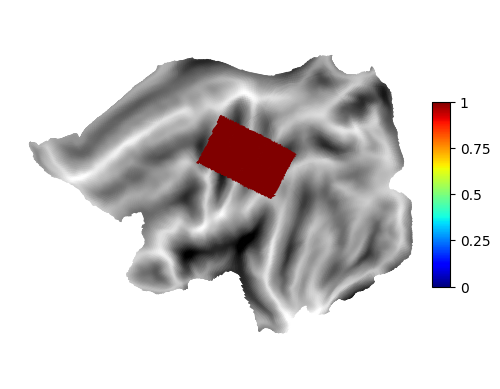

In [329]:
ax = surf.plot.plotmap(data = mask, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005)

# Smoothing

In [346]:
# Template vertex coordinates
temploate_surface_data = nb.load(template_surface_path)
vertex_locs = temploate_surface_data.darrays[0].data[:, :2]

# Data
mean_data = np.mean(surface_datas, axis = 1)
smoothed_data = gaussian_weighted_smoothing(coords = vertex_locs, 
                                            values = mean_data, 
                                            sigma = 2.0)

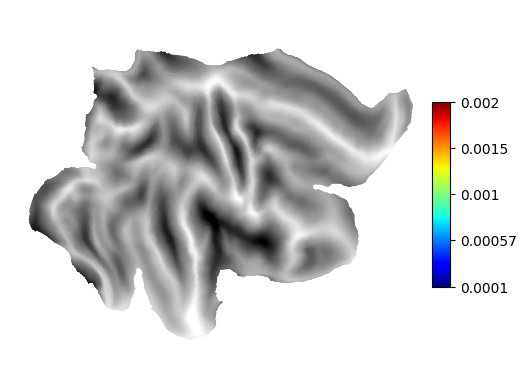

In [351]:
"""
p_threshold = 0.01
t_test_result = ttest_1samp(surface_datas, popmean = 0, axis = 1)
t_stats = t_test_result.statistic
p_values = t_test_result.pvalue
np.where((p_values < p_threshold) & (mean_data > 0), mean_data, 0)
"""

slightly_small_value = 0.0001

ax = surf.plot.plotmap(data = smoothed_data, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005,
                       cscale = [slightly_small_value, 0.002])

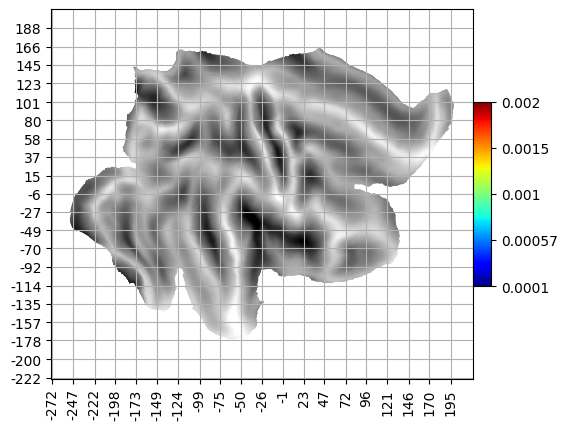

In [352]:
ax.grid(True)
ax.axis("on")
x_min, x_max = int(ax.get_xlim()[0]), int(ax.get_xlim()[1])
y_min, y_max = int(ax.get_ylim()[0]), int(ax.get_ylim()[1])

x_count = 20
y_count = 20
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)

ax.get_figure()

# Filter data only including in rectangle (from ~ to)

In [333]:
rect_vertexes = vertex_data[np.where(mask == 1, True, False)]
min_rect_x, max_rect_x = np.min(rect_vertexes[:, 0]), np.max(rect_vertexes[:, 0])
min_rect_y, max_rect_y = np.min(rect_vertexes[:, 1]), np.max(rect_vertexes[:, 1])

In [334]:
within_x = (vertex_locs[:, 0] >= min_rect_x) & (vertex_locs[:, 0] <= max_rect_x)
within_y = (vertex_locs[:, 1] >= min_rect_y) & (vertex_locs[:, 1] <= max_rect_y)

In [335]:
is_within_rectangle = np.logical_and(within_x, within_y)

In [336]:
filtered_data = np.where(is_within_rectangle, smoothed_data, 0)

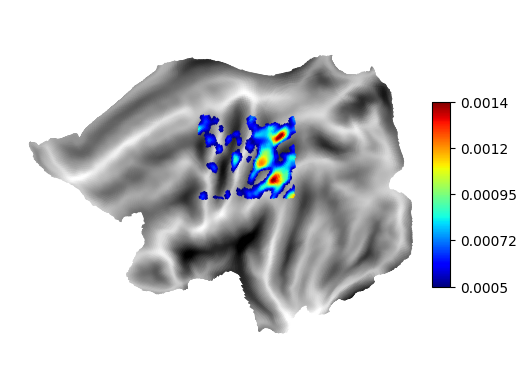

In [337]:
ax = surf.plot.plotmap(data = filtered_data, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005, 
                       cscale = [0.0005, 0.0014])

# Visualizaion

In [371]:
ttest_1samp(values, axis = 1, popmean=0).statistic

array([2.04628494, 2.46300085, 2.27566032, 2.520575  , 2.33663772,
       1.97493828, 1.65575376, 1.37966572, 1.73893673, 3.47494843])

In [374]:
ttest_1samp(values, axis = 1, popmean=0).pvalue

array([0.0518336 , 0.02133622, 0.03208179, 0.01877289, 0.02813529,
       0.05988643, 0.11079069, 0.18040946, 0.09485947, 0.00196005])

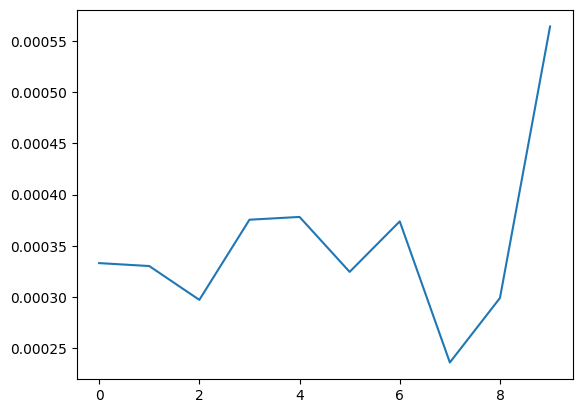

In [357]:
plt.plot(np.mean(values, axis = 1))

In [355]:
values.shape

(10, 25)